<a href="https://colab.research.google.com/github/mMitsu0/predicao_dengue/blob/main/tcc_monografia_grupo_gamma/f01_codes_modeling/dengue_previs%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CENTRO UNIVERSITÁRIO NOSSA SENHORA DO PATROCÍNIO (CEUNSP)**
SALTO - SP

**BARACHELADO EM CIÊNCIA DA COMPUTAÇÕES**

# ***Análise Comparativa de Algoritmos de Machine Learning para Predição de Casos de Dengue.***

Autores:
*Matheus Mitsuo Tomotake Santos - RGM: 30248531*
*Pedro Gavioli Pinarde - RGM: 25798006*
*Lucas Felix Nogueira -RGM: 28851994*
*Gabriel Souza Cavalcante: RGM - 30386730*

**IMPORT DAS BIBLIOTECAS NECESSÁRIAS**

In [33]:
# === IMPORTS ===

# Utilidades do sistema e dados
import os  # Interações com o sistema operacional
import pandas as pd  # Manipulação de dados em tabelas (DataFrames)
import numpy as np  # Operações numéricas

# Visualização
import matplotlib.pyplot as plt  # Criação de gráficos
import seaborn as sns  # Visualizações estatísticas com estilo

# Requisições e arquivos
import requests  # Requisições HTTP (ex: baixar dados)
from io import StringIO  # Trata strings como arquivos

# Machine Learning clássico
from sklearn.model_selection import train_test_split  # Divide dados em treino/teste
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Modelos de regressão com árvores
from sklearn.linear_model import LinearRegression  # Regressão linear
from xgboost import XGBRegressor  # Regressão com XGBoost (alta performance)
from sklearn.metrics import mean_squared_error, r2_score  # Métricas de avaliação (MSE e R²)
from sklearn.preprocessing import StandardScaler  # Normalização de features

# Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# Se estiver rodando em Jupyter, ative inline; senão ignore
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except:
    pass


**CONEXÃO COM A API E DOWNLOAD DOS DADOS**

In [34]:
import os
import requests
import pandas as pd
from io import StringIO
from datetime import datetime

# === 1. DOWNLOAD DOS DADOS ===
estados_ibge = {
    "AC": [1200401], "AL": [2704302], "AM": [1302603], "AP": [1600303],"BA": [2927408], "CE": [2304400], "DF": [5300108], "ES": [3205309],
    "GO": [5208707], "MA": [2111300], "MG": [3106200], "MS": [5002704],
    "MT": [5103403], "PA": [1501402], "PB": [2507507], "PE": [2611606],"PI": [2211001], "PR": [4106902], "RJ": [3304557], "RN": [2408102],
    "RO": [1100205], "RR": [1400100], "RS": [4314902], "SC": [4205407],
    "SE": [2800308], "SP": [3550308], "TO": [1721000]
}

def baixar_dados_por_estado(diretorio_saida="data/raw", ano_inicio=2001, ano_fim=None):
    os.makedirs(diretorio_saida, exist_ok=True)
    base_url = "https://info.dengue.mat.br/api/alertcity"
    dfs = []

    # define ano final como o ano atual se não for passado
    if ano_fim is None:
        ano_fim = datetime.now().year

    for estado, municipios in estados_ibge.items():
        for geocode in municipios:
            params = {
                "geocode": geocode,
                "disease": "dengue",
                "format": "csv",
                "ew_start": 1,
                "ew_end": 52,
                "ey_start": ano_inicio,
                "ey_end": ano_fim
            }
            url = f"{base_url}?{'&'.join([f'{k}={v}' for k,v in params.items()])}"
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    df = pd.read_csv(StringIO(response.text))
                    df["estado"] = estado
                    df["codigo_ibge"] = geocode
                    dfs.append(df)
                    print(f"✓ Dados coletados para {estado} ({ano_inicio}-{ano_fim})")
                else:
                    print(f"Falha {estado} - status {response.status_code}")
            except Exception as e:
                print(f"Erro com {estado}: {e}")

    if dfs:
        df_final = pd.concat(dfs, ignore_index=True)
        caminho_csv = f"{diretorio_saida}/dengue_{ano_inicio}_{ano_fim}_por_estado.csv"
        df_final.to_csv(caminho_csv, index=False)
        print(f"\n✅ Dados salvos em {caminho_csv}")
    else:
        print("Nenhum dado coletado.")


**REFINAMENTO DOS DADOS / FEATURES**

In [35]:
# === 2. ENGENHARIA DE FEATURES ===
def carregar_e_limpar(caminho_arquivo):
    return pd.read_csv(caminho_arquivo)

def adicionar_variaveis_temporais(df):
    df['data_iniSE'] = pd.to_datetime(df['data_iniSE'])
    df['epidemiological_year'] = df['data_iniSE'].dt.year
    df['epidemiological_week'] = df['data_iniSE'].dt.isocalendar().week

    df['casos_lag_1'] = df['casos'].shift(1)
    df['casos_lag_2'] = df['casos'].shift(2)
    df['casos_lag_3'] = df['casos'].shift(3)
    df['casos_media_3'] = df[['casos_lag_1', 'casos_lag_2', 'casos_lag_3']].mean(axis=1)
    return df

def remover_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[feature] >= Q1 - 1.5 * IQR) & (df[feature] <= Q3 + 1.5 * IQR)]
    return df

**MODELOS DE PREDIÇÃO**

In [36]:
# === 3.1 MODELOS MACHINE LEARNING ===
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def treinar_modelos_classicos(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    modelos = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(random_state=random_state),
        "Gradient Boosting": GradientBoostingRegressor(random_state=random_state),
        "XGBoost": XGBRegressor(random_state=random_state)
    }

    resultados = {}
    modelos_treinados = {}

    for nome, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        mse  = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2   = r2_score(y_test, y_pred)
        nrmse_pct = (rmse / np.mean(y_test) * 100) if np.mean(y_test) != 0 else np.nan

        resultados[nome] = (mse, rmse, r2, nrmse_pct)
        modelos_treinados[nome] = modelo

    return resultados, modelos_treinados


In [37]:
# === 3.2 LSTM
import numpy as np
import pandas as pd
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

def _ord_from_year_week(y, w):
    # número ordenável YYYYWW (apenas para ordenar/particionar)
    return int(f"{int(y):04d}{int(w):02d}")

def _build_sequences_by_state(df, features, lookback=8, horizon=1):

    X_list, y_list = [], []
    # Ordenação global por estado/tempo
    df = df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()

    for gid, g in df.groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")

        feats_arr   = g[features].to_numpy(dtype=float)
        target_arr  = g["casos"].to_numpy(dtype=float)

        if len(g) < lookback + horizon:
            continue

        for t in range(lookback, len(g) - horizon + 1):
            X_list.append(feats_arr[t - lookback:t])
            y_list.append(target_arr[t + horizon - 1])

    X = np.array(X_list)  # (n_amostras, lookback, n_features)
    y = np.array(y_list)  # (n_amostras,)
    return X, y

def _temporal_mask_by_cutoff(df, lookback, horizon, cutoff=(2025,1)):

    # Para reproduzir a mesma contagem das sequências, precisamos revarrer as chaves
    ord_cut = _ord_from_year_week(*cutoff)
    mask_list = []

    for gid, g in df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")
        if len(g) < lookback + horizon:
            continue
        # alvo na posição t+h-1
        ord_vec = g["ord"].to_numpy()
        for t in range(lookback, len(g) - horizon + 1):
            ord_target = ord_vec[t + horizon - 1]
            mask_list.append(ord_target < ord_cut)  # True=train, False=test

    mask = np.array(mask_list, dtype=bool)
    return mask

def treinar_lstm_separado(
    df_feat_sem_outliers,
    features,
    lookback=8,
    horizon=1,
    cutoff_test=(2025,1),
    epochs=80,
    batch_size=256,
    lr=1e-3,
    verbose=1
):

    # Sanidade: sem NaN nas features
    df_seq = df_feat_sem_outliers.copy()
    df_seq[features] = df_seq[features].fillna(method="ffill").fillna(method="bfill")
    df_seq["casos"] = df_seq["casos"].astype(float)

    # 1) Sequências 3D por estado
    X_all, y_all = _build_sequences_by_state(df_seq, features, lookback=lookback, horizon=horizon)
    if len(X_all) == 0:
        raise ValueError("Não foi possível construir sequências para a LSTM. Verifique se há dados suficientes por estado.")

    # 2) Máscara temporal (True=train, False=test)
    mask_train = _temporal_mask_by_cutoff(df_seq, lookback, horizon, cutoff=cutoff_test)
    if mask_train.shape[0] != X_all.shape[0]:
        raise RuntimeError("Máscara temporal não alinhada com as sequências. Verifique a preparação dos dados.")

    X_tr, y_tr = X_all[mask_train], y_all[mask_train]
    X_te, y_te = X_all[~mask_train], y_all[~mask_train]

    # 3) Escalonamento apenas nas features (concatenando no eixo tempo)
    n_features = X_tr.shape[-1]
    scaler = StandardScaler()
    X_tr_2d = X_tr.reshape(-1, n_features)
    scaler.fit(X_tr_2d)

    X_tr_scaled = scaler.transform(X_tr_2d).reshape(X_tr.shape)
    X_te_scaled = scaler.transform(X_te.reshape(-1, n_features)).reshape(X_te.shape)

    # 4) Modelo LSTM
    def build_lstm(input_shape, lr=lr):
        inp = layers.Input(shape=input_shape)
        x = layers.LSTM(64, return_sequences=True)(inp)
        x = layers.Dropout(0.2)(x)
        x = layers.LSTM(32)(x)
        x = layers.Dense(16, activation="relu")(x)
        out = layers.Dense(1)(x)
        model = models.Model(inp, out)
        model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
        return model

    model_lstm = build_lstm((lookback, n_features), lr=lr)
    early = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    plateau = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")

    # 5) Treino
    hist = model_lstm.fit(
        X_tr_scaled, y_tr,
        validation_split=0.15,  # validação dentro do conjunto de treino (temporalmente já separou o teste)
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early, plateau],
        verbose=verbose
    )

    # 6) Avaliação
    y_hat_tr = model_lstm.predict(X_tr_scaled, verbose=0).ravel()
    y_hat_te = model_lstm.predict(X_te_scaled, verbose=0).ravel()

    def _metrics(y_true, y_pred):
        mse  = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2   = r2_score(y_true, y_pred)
        nrmse_pct = (rmse / np.mean(y_true) * 100) if np.mean(y_true) != 0 else np.nan
        return mse, rmse, r2, nrmse_pct

    mse_tr, rmse_tr, r2_tr, nrmse_tr = _metrics(y_tr, y_hat_tr)
    mse_te, rmse_te, r2_te, nrmse_te = _metrics(y_te, y_hat_te)

    print("\n=== LSTM - Métricas (Treino) ===")
    print(f"MSE (u²): {mse_tr:,.2f} | RMSE: {rmse_tr:,.2f} | R²: {r2_tr*100:,.2f}% | nRMSE: {nrmse_tr:,.2f}%")
    print("=== LSTM - Métricas (Teste)  ===")
    print(f"MSE (u²): {mse_te:,.2f} | RMSE: {rmse_te:,.2f} | R²: {r2_te*100:,.2f}% | nRMSE: {nrmse_te:,.2f}%")

    resultados_lstm = {"LSTM": (mse_te, rmse_te, r2_te, nrmse_te)}
    return resultados_lstm, model_lstm, scaler


**PLOTAGEM E AVALIAÇÃO DOS MODELOS**

In [38]:
def plot_comparacao_erros(modelos, mse_percentuais):
    df = pd.DataFrame({"Modelo": modelos, "Erro (%)": mse_percentuais})
    plt.figure(figsize=(10,6))
    sns.barplot(data=df, x="Modelo", y="Erro (%)", hue="Modelo", palette="viridis", legend=False)
    plt.title('Erro Quadrático Médio (%) por Modelo')
    plt.ylabel('Erro (%)')
    plt.xlabel('Modelos')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**MAIN**

✓ Dados coletados para AC (2010-2025)
✓ Dados coletados para AL (2010-2025)
✓ Dados coletados para AM (2010-2025)
✓ Dados coletados para AP (2010-2025)
✓ Dados coletados para BA (2010-2025)
✓ Dados coletados para CE (2010-2025)
✓ Dados coletados para DF (2010-2025)
✓ Dados coletados para ES (2010-2025)
✓ Dados coletados para GO (2010-2025)
✓ Dados coletados para MA (2010-2025)
✓ Dados coletados para MG (2010-2025)
✓ Dados coletados para MS (2010-2025)
✓ Dados coletados para MT (2010-2025)
✓ Dados coletados para PA (2010-2025)
✓ Dados coletados para PB (2010-2025)
✓ Dados coletados para PE (2010-2025)
✓ Dados coletados para PI (2010-2025)
✓ Dados coletados para PR (2010-2025)
✓ Dados coletados para RJ (2010-2025)
✓ Dados coletados para RN (2010-2025)
✓ Dados coletados para RO (2010-2025)
✓ Dados coletados para RR (2010-2025)
✓ Dados coletados para RS (2010-2025)
✓ Dados coletados para SC (2010-2025)
✓ Dados coletados para SE (2010-2025)
✓ Dados coletados para SP (2010-2025)
✓ Dados cole

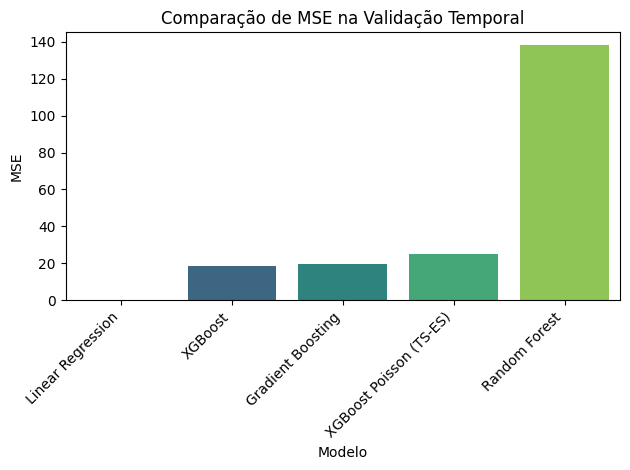

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature name

Epoch 1/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 34.9102 - val_loss: 29.7477 - learning_rate: 0.0010
Epoch 2/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 32.7026 - val_loss: 27.1202 - learning_rate: 0.0010
Epoch 3/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 28.5733 - val_loss: 24.3489 - learning_rate: 0.0010
Epoch 4/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 25.4020 - val_loss: 23.3050 - learning_rate: 0.0010
Epoch 5/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 23.7908 - val_loss: 22.5001 - learning_rate: 0.0010
Epoch 6/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 22.2631 - val_loss: 19.5652 - learning_rate: 0.0010
Epoch 7/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 19.7033 - val_loss: 17.7630 - learning_rate: 0.0010
Epoch 8/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 17.6864 - val_loss: 16.1863 - learning_rate: 0.0010
Epoch 9/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 15.4435 - val_loss: 14.5805 - learning_rate:

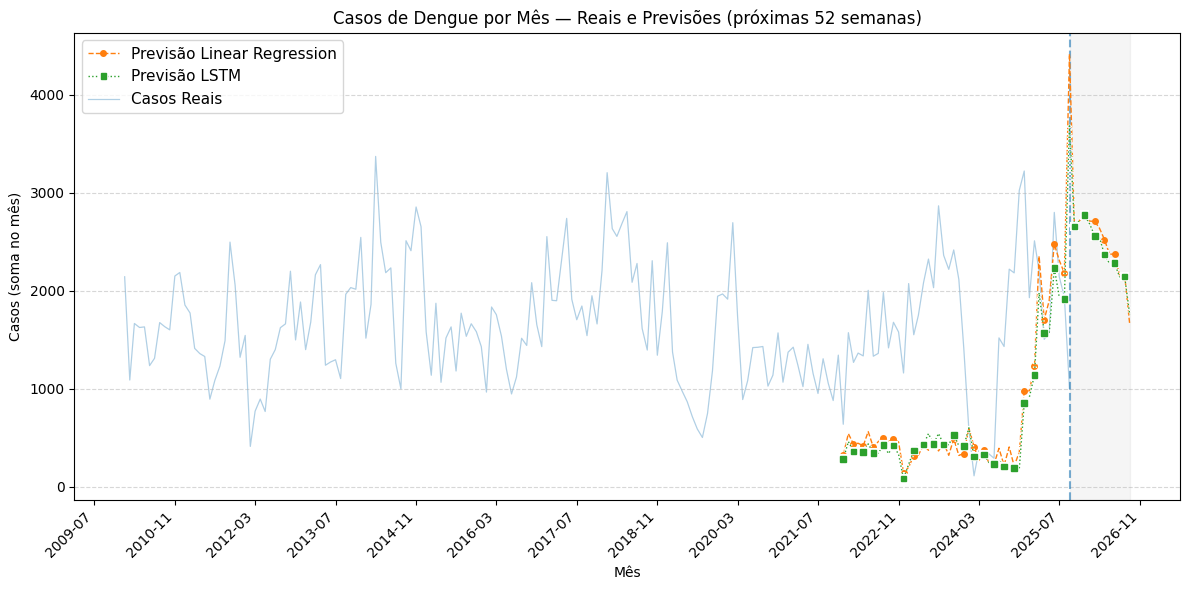

In [40]:
# === 5. EXECUÇÃO COMPLETA  (TS-SPLIT, XGB Poisson, LSTM e PLOT MENSAL) ===
import os
from glob import glob
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.dates as mdates

# xgboost
import xgboost as xgb
from xgboost import XGBRegressor

# modelos clássicos e métricas
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# LSTM
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.losses import Huber  # << Huber para perda robusta

# --------------------------
# Configuração de anos (um único range para todo o pipeline)
# --------------------------
ANO_INICIO = 2010
ANO_FIM    = 2025

# ====== horizonte de previsão (semanas) ======
# 26 ≈ 6 meses | 52 ≈ 1 ano
N_FUTURO_SEMANAS = 52

# --------------------------
# Helpers gerais
# --------------------------
def yw_to_month_start(y, w):
    """(ano, semana ISO) -> primeiro dia do mês (robusto a semana 53)"""
    y, w = int(y), int(w)
    try:
        d = date.fromisocalendar(y, w, 1)
    except ValueError:
        d = date.fromisocalendar(y, 52, 1)  # fallback
    return d.replace(day=1)

def _ord_from_year_week(y, w):
    return int(f"{int(y):04d}{int(w):02d}")

# ===== Feature engineering rápido =====
def add_extra_features(df):
    g = df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()
    # lags de casos (1..12)
    for lag in [1,2,3,4,8,12]:
        g[f"casos_lag_{lag}"] = g.groupby("codigo_ibge")["casos"].shift(lag)
    # médias móveis (nome mantido como no seu código - mm3/mm5)
    g["casos_mm3"] = g.groupby("codigo_ibge")["casos"].rolling(3).mean().reset_index(0,drop=True)
    g["casos_mm5"] = g.groupby("codigo_ibge")["casos"].rolling(5).mean().reset_index(0,drop=True)
    # sazonalidade anual (Fourier)
    w = g["epidemiological_week"].astype(float)
    g["week_sin"] = np.sin(2*np.pi*w/52.18)
    g["week_cos"] = np.cos(2*np.pi*w/52.18)
    # lags climáticos
    for col in ["tempmin","umidmax"]:
        g[f"{col}_lag1"] = g.groupby("codigo_ibge")[col].shift(1)
        g[f"{col}_lag2"] = g.groupby("codigo_ibge")[col].shift(2)
    return g

# pesos temporais (dão mais importância às semanas recentes)
def time_weights(ord_series, power=1.0):  # << menos peso ao mais recente (era 1.4)
    omin, omax = ord_series.min(), ord_series.max()
    if omax == omin:
        return np.ones_like(ord_series, dtype=float)
    return ((ord_series - omin) / (omax - omin) + 0.01) ** power

# --------------------------
# LSTM
# --------------------------
def _build_sequences_by_state(df, features, lookback=8, horizon=1):
    X_list, y_list = [], []
    df = df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()
    for gid, g in df.groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")
        feats_arr = g[features].to_numpy(dtype=float)
        target_arr = g["casos"].to_numpy(dtype=float)
        if len(g) < lookback + horizon:
            continue
        for t in range(lookback, len(g) - horizon + 1):
            X_list.append(feats_arr[t - lookback:t])
            y_list.append(target_arr[t + horizon - 1])
    X = np.array(X_list); y = np.array(y_list)
    return X, y

def _temporal_mask_by_cutoff(df, lookback, horizon, cutoff=(2025,1)):
    ord_cut = _ord_from_year_week(*cutoff)
    mask_list = []
    for gid, g in df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")
        if len(g) < lookback + horizon:
            continue
        ord_vec = g["ord"].to_numpy()
        for t in range(lookback, len(g) - horizon + 1):
            ord_target = ord_vec[t + horizon - 1]
            mask_list.append(ord_target < ord_cut)
    return np.array(mask_list, dtype=bool)

def treinar_lstm_separado(
    df_feat_sem_outliers,
    features,
    lookback=12,
    horizon=1,
    cutoff_test=(2025,1),
    epochs=120,
    batch_size=256,
    lr=1e-3,
    verbose=1
):
    df_seq = df_feat_sem_outliers.copy()
    df_seq[features] = df_seq[features].ffill().bfill()
    df_seq["casos"] = df_seq["casos"].astype(float)

    X_all, y_all = _build_sequences_by_state(df_seq, features, lookback=lookback, horizon=horizon)
    if len(X_all) == 0:
        raise ValueError("Sem dados suficientes para LSTM. Verifique lookback/horizon.")

    mask_train = _temporal_mask_by_cutoff(df_seq, lookback, horizon, cutoff=cutoff_test)
    if mask_train.shape[0] != X_all.shape[0]:
        raise RuntimeError("Máscara temporal desalinhada.")

    X_tr, y_tr = X_all[mask_train], y_all[mask_train]
    X_te, y_te = X_all[~mask_train], y_all[~mask_train]

    n_features = X_tr.shape[-1]
    scaler = StandardScaler()
    X_tr_2d = X_tr.reshape(-1, n_features)
    scaler.fit(X_tr_2d)
    X_tr_scaled = scaler.transform(X_tr_2d).reshape(X_tr.shape)
    X_te_scaled = scaler.transform(X_te.reshape(-1, n_features)).reshape(X_te.shape)

    def build_lstm(input_shape, lr=lr):
        inp = layers.Input(shape=input_shape)
        x = layers.LSTM(64, return_sequences=True)(inp)
        x = layers.Dropout(0.2)(x)
        x = layers.LSTM(32)(x)
        x = layers.Dense(16, activation="relu")(x)
        out = layers.Dense(1, activation="softplus")(x)  # << saída positiva e suave
        model = models.Model(inp, out)
        model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=Huber(delta=1.0))  # << perda robusta
        return model

    model_lstm = build_lstm((lookback, n_features), lr=lr)
    early = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    plateau = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")

    model_lstm.fit(
        X_tr_scaled, y_tr,
        validation_split=0.15,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early, plateau],
        verbose=verbose
    )

    def _metrics(y_true, y_pred):
        mse = np.mean((y_true - y_pred) ** 2); rmse = float(np.sqrt(mse))
        ss_res = np.sum((y_true - y_pred) ** 2); ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
        nrmse_pct = (rmse / np.mean(y_true)) * 100 if np.mean(y_true) != 0 else np.nan
        return mse, rmse, r2, nrmse_pct

    y_hat_tr = model_lstm.predict(X_tr_scaled, verbose=0).ravel()
    y_hat_te = model_lstm.predict(X_te_scaled, verbose=0).ravel()

    mse_tr, rmse_tr, r2_tr, nrmse_tr = _metrics(y_tr, y_hat_tr)
    mse_te, rmse_te, r2_te, nrmse_te = _metrics(y_te, y_hat_te)

    print("\n=== LSTM - Métricas (Treino) ===")
    print(f"MSE (u²): {mse_tr:,.2f} | RMSE: {rmse_tr:,.2f} | R²: {r2_tr*100:,.2f}% | nRMSE: {nrmse_tr:,.2f}%")
    print("=== LSTM - Métricas (Teste)  ===")
    print(f"MSE (u²): {mse_te:,.2f} | RMSE: {rmse_te:,.2f} | R²: {r2_te*100:,.2f}% | nRMSE: {nrmse_te:,.2f}%")

    resultados_lstm = {"LSTM": (mse_te, rmse_te, r2_te, nrmse_te)}
    return resultados_lstm, model_lstm, scaler, lookback

# ===== previsão LSTM para N semanas (genérica) =====
def prever_n_semanas_lstm(df_feat_sem_outliers, features, model_lstm, scaler, lookback, n_weeks=26):
    df = df_feat_sem_outliers.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()
    last_windows = {}
    for gid, g in df.groupby("codigo_ibge"):
        if len(g) < lookback:
            continue
        last_windows[gid] = g.iloc[-lookback:].copy()

    fut_rows = []
    # índices dos campos que atualizamos durante a simulação
    idx_lag1 = features.index("casos_lag_1") if "casos_lag_1" in features else None
    idx_med3 = features.index("casos_media_3") if "casos_media_3" in features else None

    for gid, win_df in last_windows.items():
        win_vals = win_df[features].to_numpy(dtype=float)  # (lookback, n_features)
        y_last = int(win_df.iloc[-1]["epidemiological_year"])
        w_last = int(win_df.iloc[-1]["epidemiological_week"])

        for _ in range(n_weeks):
            X_in = scaler.transform(win_vals)
            y_pred = float(model_lstm.predict(X_in[np.newaxis, ...], verbose=0).ravel()[0])
            y_pred = max(0.0, y_pred)
            # aplica teto FUT_CAP se existir no escopo
            if 'FUT_CAP' in globals() and FUT_CAP is not None:
                y_pred = min(y_pred, FUT_CAP)

            # atualiza lags/médias
            new_row = win_vals[-1].copy()
            if idx_lag1 is not None:
                new_row[idx_lag1] = y_pred
            if idx_med3 is not None:
                last_lag1_series = win_vals[-2:, idx_lag1] if win_vals.shape[0] >= 2 else np.array([])
                vals = list(last_lag1_series) + [y_pred]
                new_row[idx_med3] = np.mean(vals)

            # avança 1 semana ISO
            d = date.fromisocalendar(y_last, w_last, 1) + timedelta(weeks=1)
            iso = d.isocalendar(); y_last, w_last = int(iso[0]), int(iso[1])

            fut_rows.append({
                "codigo_ibge": gid,
                "epidemiological_year": y_last,
                "epidemiological_week": w_last,
                "casos_previstos_lstm": y_pred
            })
            # deslizante
            win_vals = np.vstack([win_vals[1:], new_row])

    return pd.DataFrame(fut_rows)

# --------------------------
# Modelos clássicos com split temporal + XGB Poisson ES
# --------------------------
def treinar_modelos(X, y, ord_vec, val_weeks=8):
    """
    Split temporal: últimas `val_weeks` semanas são validação.
    ord_vec: vetor inteiro AAAASW alinhado a X,y.
    """
    # --- split temporal
    ords = np.sort(np.unique(ord_vec))
    val_ords = ords[-val_weeks:] if len(ords) > val_weeks else ords[-max(1, len(ords)//5):]
    mask_val = np.isin(ord_vec, val_ords)
    mask_tr  = ~mask_val

    X_tr, y_tr = X[mask_tr], y[mask_tr]
    X_val, y_val = X[mask_val], y[mask_val]

    # --- pesos temporais (mais peso pro recente)  << mais suave
    w_tr = time_weights(ord_vec[mask_tr], power=1.0)

    # --- modelos sklearn "clássicos" (mais conservadores)
    modelos = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(
            random_state=42, n_estimators=800, max_features="sqrt",
            max_depth=12, min_samples_leaf=5
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            random_state=42, n_estimators=1000, learning_rate=0.05, max_depth=3
        ),
        "XGBoost": XGBRegressor(
            random_state=42, n_estimators=1500, learning_rate=0.03, max_depth=4,
            min_child_weight=5, subsample=0.9, colsample_bytree=0.9,
            reg_lambda=2.0, reg_alpha=0.1, tree_method="hist"
        ),
    }

    resultados, modelos_treinados = {}, {}

    for nome, modelo in modelos.items():
        try:
            modelo.fit(X_tr, y_tr, sample_weight=w_tr)
        except TypeError:
            modelo.fit(X_tr, y_tr)
        y_hat = modelo.predict(X_val)
        resultados[nome] = (mean_squared_error(y_val, y_hat), r2_score(y_val, y_hat))
        modelos_treinados[nome] = modelo

    # --- XGBoost Poisson com early stopping usando xgb.train
    dtr  = xgb.DMatrix(X_tr, label=y_tr, weight=w_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        "objective": "count:poisson",
        "eval_metric": "poisson-nloglik",
        "tree_method": "hist",
        "random_state": 42,
        "eta": 0.03,
        "max_depth": 6,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "lambda": 1.0,
    }
    # << regularização extra no booster Poisson
    params.update({"max_depth": 4, "min_child_weight": 5, "lambda": 2.0, "alpha": 0.1})

    booster = xgb.train(
        params,
        dtr,
        num_boost_round=5000,
        evals=[(dval, "val")],
        early_stopping_rounds=200,
        verbose_eval=False
    )

    class XGBPoissonWrapper:
        def __init__(self, booster):
            self.booster = booster
        def predict(self, X_):
            return self.booster.predict(xgb.DMatrix(X_))

    xgb_poisson_model = XGBPoissonWrapper(booster)
    y_hat_p = xgb_poisson_model.predict(X_val)

    resultados["XGBoost Poisson (TS-ES)"] = (mean_squared_error(y_val, y_hat_p), r2_score(y_val, y_hat_p))
    modelos_treinados["XGBoost Poisson (TS-ES)"] = xgb_poisson_model

    return resultados, modelos_treinados

# --------------------------
# Fluxo principal
# --------------------------

# Passo 1 — Download com o mesmo range usado no restante do pipeline
baixar_dados_por_estado(ano_inicio=ANO_INICIO, ano_fim=ANO_FIM)

# Passo 2 — Carregar o arquivo correto (com fallback se não existir)
caminho_csv = f"data/raw/dengue_{ANO_INICIO}_{ANO_FIM}_por_estado.csv"
if not os.path.exists(caminho_csv):
    candidatos = sorted(glob("data/raw/dengue_*_por_estado.csv"))
    if candidatos:
        print(f"⚠️ Arquivo {caminho_csv} não encontrado. Usando {candidatos[-1]}")
        caminho_csv = candidatos[-1]
    else:
        raise FileNotFoundError("Nenhum CSV de dengue encontrado em data/raw/. Verifique o download.")

df = carregar_e_limpar(caminho_csv)
df_feat = adicionar_variaveis_temporais(df)

# >>> novas features
df_feat = add_extra_features(df_feat)

# preenche NaN gerados por lags (primeiras semanas de cada estado) — sem warnings
df_feat = df_feat.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()

cols_to_fill = list(set(
    [
        "casos",
        "casos_lag_1","casos_lag_2","casos_lag_3","casos_lag_4","casos_lag_8","casos_lag_12",
        "casos_mm3","casos_mm5",
        "week_sin","week_cos",
        "pop","tempmin","umidmax","tempmin_lag1","tempmin_lag2","umidmax_lag1","umidmax_lag2",
        "receptivo","transmissao",
        # alguns fluxos usam "casos_media_3"; garantimos a coluna:
        "casos_media_3"
    ]
))
for col in cols_to_fill:
    if col in df_feat.columns:
        df_feat[col] = df_feat.groupby("codigo_ibge")[col].transform(lambda s: s.ffill().bfill())

# se "casos_media_3" não existia, cria a partir dos lags
if "casos_media_3" in df_feat.columns:
    mask_missing = df_feat["casos_media_3"].isna()
    if mask_missing.any():
        df_feat.loc[mask_missing, "casos_media_3"] = (
            df_feat.loc[mask_missing, ["casos_lag_1","casos_lag_2","casos_lag_3"]].mean(axis=1)
        )

# selecione features (incluindo as novas)
features = [
    "casos_lag_1","casos_lag_2","casos_lag_3","casos_lag_4","casos_lag_8","casos_lag_12",
    "casos_mm3","casos_mm5",
    "week_sin","week_cos",
    "pop","tempmin","umidmax","tempmin_lag1","tempmin_lag2","umidmax_lag1","umidmax_lag2",
    "receptivo","transmissao",
    # compatibilidade com função de previsão LSTM
    "casos_media_3"
]

df_feat_sem_outliers = remover_outliers(df_feat, features)

# vetor temporal para split/weights
ord_vec = (df_feat_sem_outliers["epidemiological_year"].astype(int)*100 +
           df_feat_sem_outliers["epidemiological_week"].astype(int)).values

# treino temporal + ES
X = df_feat_sem_outliers[features].values
y = df_feat_sem_outliers["casos"].values.astype(float)

# >>> TETO FUTURO (98º percentil * 1.25) para evitar explosões
p98 = np.percentile(y[~np.isnan(y)], 98)
FUT_CAP = float(p98 * 1.25)

resultados, modelos_treinados = treinar_modelos(X, y, ord_vec, val_weeks=8)

# escolha automática do melhor (menor MSE)
modelo_escolhido_nome = min(resultados.keys(), key=lambda k: resultados[k][0])
modelo_escolhido = modelos_treinados[modelo_escolhido_nome]
print(f"\n>>> Modelo escolhido: {modelo_escolhido_nome}")

# ===== Avaliação (val temporal) — gráfico de MSE
df_mse = (
    pd.DataFrame([(k, v[0]) for k, v in resultados.items()], columns=["Modelo","MSE"])
      .sort_values("MSE")
)
sns.barplot(data=df_mse, x="Modelo", y="MSE", hue="Modelo", palette="viridis", legend=False)
plt.title("Comparação de MSE na Validação Temporal")
plt.ylabel("MSE"); plt.xlabel("Modelo"); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

# ===== Previsões no histórico (in-sample)
df_feat_sem_outliers["casos_previstos_in_sample"] = np.clip(modelo_escolhido.predict(X), 0, None)

# ===== Função para avançar 1 semana ISO
def advance_iso_week_vectorized(years, weeks):
    new_years, new_weeks = [], []
    for y_, w_ in zip(years, weeks):
        d = date.fromisocalendar(int(y_), int(w_), 1) + timedelta(weeks=1)
        iso = d.isocalendar()
        new_years.append(int(iso[0])); new_weeks.append(int(iso[1]))
    return pd.Series(new_years), pd.Series(new_weeks)

# ===== Preparação dos últimos registros por estado
ultimos_registros = (
    df_feat_sem_outliers
    .sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"])
    .groupby("codigo_ibge").tail(1).copy()
)
for col in ["casos_lag_1","casos_lag_2","casos_lag_3","casos_media_3"]:
    if col not in ultimos_registros.columns:
        ultimos_registros[col] = np.nan
ultimos_registros["casos_lag_1"] = ultimos_registros["casos_lag_1"].fillna(ultimos_registros.get("casos", 0))
ultimos_registros["casos_lag_2"] = ultimos_registros["casos_lag_2"].fillna(ultimos_registros["casos_lag_1"])
ultimos_registros["casos_lag_3"] = ultimos_registros["casos_lag_3"].fillna(ultimos_registros["casos_lag_2"])
ultimos_registros["casos_media_3"] = ultimos_registros["casos_media_3"].fillna(
    ultimos_registros[["casos_lag_1","casos_lag_2","casos_lag_3"]].mean(axis=1)
)

# ===== Previsão de N_FUTURO_SEMANAS (modelo escolhido)
previsoes_futuras = []
for _ in range(N_FUTURO_SEMANAS):
    X_input = ultimos_registros[features].copy()
    y_pred = np.clip(modelo_escolhido.predict(X_input), 0, FUT_CAP)  # << aplica teto
    # atualiza lags
    ultimos_registros["casos_lag_3"] = ultimos_registros["casos_lag_2"]
    ultimos_registros["casos_lag_2"] = ultimos_registros["casos_lag_1"]
    ultimos_registros["casos_lag_1"] = y_pred
    ultimos_registros["casos_media_3"] = ultimos_registros[["casos_lag_1","casos_lag_2","casos_lag_3"]].mean(axis=1)
    # avança semana
    new_years, new_weeks = advance_iso_week_vectorized(
        ultimos_registros["epidemiological_year"].values,
        ultimos_registros["epidemiological_week"].values
    )
    ultimos_registros["epidemiological_year"] = new_years.values
    ultimos_registros["epidemiological_week"] = new_weeks.values
    snap = ultimos_registros.copy(); snap["casos_previstos"] = y_pred
    previsoes_futuras.append(snap)

df_previsoes_futuras = pd.concat(previsoes_futuras, ignore_index=True)
df_previsoes_futuras["casos_previstos"] = df_previsoes_futuras["casos_previstos"].astype(float)

# ===== Treina LSTM e prevê N_FUTURO_SEMANAS
res_lstm, model_lstm, scaler_lstm, lookback = treinar_lstm_separado(
    df_feat_sem_outliers, features,
    lookback=12, horizon=1, cutoff_test=(2025,1),
    epochs=120, batch_size=256, lr=1e-3, verbose=1
)
df_previsoes_futuras_lstm = prever_n_semanas_lstm(
    df_feat_sem_outliers, features, model_lstm, scaler_lstm, lookback,
    n_weeks=N_FUTURO_SEMANAS
)

# ===== Plot =====
# Reais
real_m = df_feat_sem_outliers.copy()
real_m["mes_dt"] = real_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
real_m = real_m.groupby("mes_dt")["casos"].sum().reset_index().rename(columns={"casos":"Casos Reais"})
# Clássico escolhido
xgb_m = df_previsoes_futuras.copy()
xgb_m["mes_dt"] = xgb_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
xgb_m = xgb_m.groupby("mes_dt")["casos_previstos"].sum().reset_index().rename(columns={"casos_previstos":f"Previsão {modelo_escolhido_nome}"})
# LSTM
lstm_m = df_previsoes_futuras_lstm.copy()
lstm_m["mes_dt"] = lstm_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
lstm_m = lstm_m.groupby("mes_dt")["casos_previstos_lstm"].sum().reset_index().rename(columns={"casos_previstos_lstm":"Previsão LSTM"})

df_month = (real_m.merge(xgb_m, on="mes_dt", how="outer")
                  .merge(lstm_m, on="mes_dt", how="outer")
                  .sort_values("mes_dt"))

ultimo_mes_real = real_m["mes_dt"].max() if len(real_m) else None

# === Guardrails sazonais por mês (cap + blend) ===
if len(real_m):
    # Estatísticas históricas por mês (somente até o último mês real)
    real_hist = real_m[real_m["mes_dt"] <= ultimo_mes_real].copy() if ultimo_mes_real is not None else real_m.copy()
    real_hist["mes_num"] = pd.to_datetime(real_hist["mes_dt"]).dt.month
    saz = (real_hist
           .groupby("mes_num")["Casos Reais"]
           .agg(mediana="median", p90=lambda s: np.percentile(s, 90))
           .reset_index())

    # Mapa mês -> (mediana, teto)
    saz_map = {int(r.mes_num): (float(r.mediana), float(r.p90) * 1.10)
               for r in saz.itertuples(index=False)}

    def aplica_trilhos(col):
        """Faz blend com a mediana histórica do mês e aplica teto p90*1.10."""
        if col not in df_month.columns:
            return
        mask_fut = df_month["mes_dt"] > ultimo_mes_real if ultimo_mes_real is not None else df_month["mes_dt"] >= df_month["mes_dt"].min()
        if not mask_fut.any():
            return

        meses = pd.to_datetime(df_month.loc[mask_fut, "mes_dt"]).dt.month
        preds = df_month.loc[mask_fut, col].astype(float).values

        alpha = 0.60  # peso da previsão (reduza p/ 0.50 se ainda ficar alto)
        blends = []
        for val, m in zip(preds, meses):
            med, cap = saz_map.get(int(m), (np.nan, np.nan))
            if not np.isfinite(med):
                med = np.nanmedian(preds)
            if not np.isfinite(cap):
                cap = np.nanpercentile(preds, 90) * 1.10
            b = alpha * val + (1 - alpha) * med   # puxa para a mediana do mês
            b = min(b, cap)                        # limita por teto sazonal
            blends.append(b)

        df_month.loc[mask_fut, col] = blends

    aplica_trilhos(f"Previsão {modelo_escolhido_nome}")
    aplica_trilhos("Previsão LSTM")

# === Suavização EMA só no trecho futuro (deixa o horizonte mais uniforme)
def _ema(series, alpha=0.35):
    vals = series.values.astype(float)
    if len(vals) == 0: return series
    out = np.empty_like(vals, dtype=float)
    out[0] = vals[0]
    for i in range(1, len(vals)):
        out[i] = alpha*vals[i] + (1-alpha)*out[i-1]
    return pd.Series(out, index=series.index)

if ultimo_mes_real is not None:
    mask_fut = df_month["mes_dt"] > ultimo_mes_real
    for col in [f"Previsão {modelo_escolhido_nome}", "Previsão LSTM"]:
        if col in df_month.columns:
            df_month.loc[mask_fut, col] = _ema(
                df_month.loc[mask_fut, col].ffill().bfill()
            )

# --- plot manual para controlar espessuras e destaque ---
df_real = df_month[["mes_dt", "Casos Reais"]].dropna()
df_xgb  = df_month[["mes_dt", f"Previsão {modelo_escolhido_nome}"]].dropna()
df_lstm = df_month[["mes_dt", "Previsão LSTM"]].dropna()

fig, ax = plt.subplots(figsize=(12, 6))

# Casos Reais
ax.plot(
    df_real["mes_dt"], df_real["Casos Reais"],
    label="Casos Reais",
    linewidth=0.9, alpha=0.35, linestyle="-", zorder=1
)

# Previsão modelo escolhido
line_xgb, = ax.plot(
    df_xgb["mes_dt"], df_xgb[f"Previsão {modelo_escolhido_nome}"],
    label=f"Previsão {modelo_escolhido_nome}",
    linewidth=1.0, linestyle="--", marker="o", markersize=4, markevery=2,
    zorder=5
)

# Previsão LSTM — fino
line_lstm, = ax.plot(
    df_lstm["mes_dt"], df_lstm["Previsão LSTM"],
    label="Previsão LSTM",
    linewidth=1.0, linestyle=":", marker="s", markersize=4, markevery=2,
    zorder=6
)
line_lstm.set_path_effects([pe.Stroke(linewidth=3.0, foreground="white"), pe.Normal()])

# Linha e faixa futuras
if ultimo_mes_real is not None:
    x0 = ultimo_mes_real + timedelta(days=1)
    ax.axvline(x0, linestyle="--", alpha=0.6, zorder=2)
    xmax = df_month["mes_dt"].max()
    if xmax is not None and xmax > x0:
        ax.axvspan(x0, xmax, color="gray", alpha=0.08, zorder=0)

ax.set_title("Casos de Dengue por Mês — Reais e Previsões (próximas {} semanas)".format(N_FUTURO_SEMANAS))
ax.set_xlabel("Mês"); ax.set_ylabel("Casos (soma no mês)")
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Eixo X mensal legível
if len(df_month):
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(df_month)//12)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45, ha='right')

# Legenda: previsões primeiro
handles, labels = ax.get_legend_handles_labels()
order = [1, 2, 0]
ax.legend([handles[i] for i in order], [labels[i] for i in order], title="", fontsize=11, loc="upper left")

plt.tight_layout()
plt.show()
